# LLM-Assisted AI Incident Forecasting

## Pipeline Overview

```
[AI Incident Data] → [Preprocess + Augment] → [Retriever Index]
      ↓
[Prompt Generator] → [LLM Forecast Engine] → [Evals + Results]
```

## 1. Data Ingestion & Augmentation


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# MongoDB integration
import os

# For embeddings and retrieval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Notebook helper functions
from llm_mongo_utils import (
    parse_mongodb_list_field,
    merge_classifications_with_incidents,
    categorize_risk_domain_enhanced,
    categorize_entity_type_enhanced,
    extract_region_enhanced,
    create_enhanced_description,
    get_related_reports,
    connect_to_mongodb,
    load_incidents_from_mongo,
    load_reports_from_mongo,
    load_classifications_from_mongo,
)

# Vector database retriever
from vector_retriever import (
    EnhancedIncidentRetriever,
    save_retriever,
    load_retriever,
    CHROMADB_AVAILABLE
)

# For LLM integration with Ollama
import ollama

print("Libraries imported successfully")
print(f"ChromaDB available: {CHROMADB_AVAILABLE}")


In [ ]:

# Connect to MongoDB and load data
mongo_client = connect_to_mongodb()
incidents_df = pd.DataFrame()
reports_df = pd.DataFrame()
classifications_df = pd.DataFrame()

if mongo_client:
    incidents_df = load_incidents_from_mongo(mongo_client)
    reports_df = load_reports_from_mongo(mongo_client)
    classifications_df = load_classifications_from_mongo(mongo_client)

    print(f"\nDataset Info:")
    print(f"Incidents: {incidents_df.shape}")
    print(f"Reports: {reports_df.shape}")
    print(f"Classifications: {classifications_df.shape}")

    if not incidents_df.empty:
        print(f"\nIncidents date range: {incidents_df['date'].min()} to {incidents_df['date'].max()}")
        print("\nIncident columns:", list(incidents_df.columns))

    if not reports_df.empty:
        print(f"\nReports columns:", list(reports_df.columns))
        if 'date_published' in reports_df.columns:
            valid_dates = reports_df['date_published'].notna().sum()
            print(f"Reports with valid publication dates: {valid_dates}")

    if not classifications_df.empty:
        print(f"\nClassifications columns:", list(classifications_df.columns))
        if 'beginning_date' in classifications_df.columns:
            valid_dates = classifications_df['beginning_date'].notna().sum()
            print(f"Classifications with valid beginning dates: {valid_dates}")
        if 'incidents' in classifications_df.columns:
            linked_incidents = classifications_df['incidents'].apply(
                lambda x: len(x) if isinstance(x, list) else 0
            ).sum()
            print(f"Total incident links in classifications: {linked_incidents}")

In [ ]:
# Data preprocessing and categorization for MongoDB data with classifications integration

if not incidents_df.empty:
    if not classifications_df.empty:
        incidents_df = merge_classifications_with_incidents(incidents_df, classifications_df)

    if 'Alleged deployer of AI system' in incidents_df.columns:
        incidents_df['deployer_list'] = incidents_df['Alleged deployer of AI system'].apply(
            parse_mongodb_list_field
        )
    else:
        incidents_df['deployer_list'] = [[]] * len(incidents_df)

    if 'Alleged developer of AI system' in incidents_df.columns:
        incidents_df['developer_list'] = incidents_df['Alleged developer of AI system'].apply(
            parse_mongodb_list_field
        )
    else:
        incidents_df['developer_list'] = [[]] * len(incidents_df)

    if 'Alleged harmed or nearly harmed parties' in incidents_df.columns:
        incidents_df['harmed_parties_list'] = incidents_df[
            'Alleged harmed or nearly harmed parties'
        ].apply(parse_mongodb_list_field)
    else:
        incidents_df['harmed_parties_list'] = [[]] * len(incidents_df)

    incidents_df['year'] = incidents_df['date'].dt.year
    incidents_df['month'] = incidents_df['date'].dt.month
    incidents_df['quarter'] = incidents_df['date'].dt.quarter

    if 'Risk Domain' not in incidents_df.columns:
        def safe_categorize_risk_domain(row):
            try:
                return categorize_risk_domain_enhanced(row)
            except (ValueError, TypeError) as e:
                print(f"Error categorizing risk domain: {e}")
                return 'Other'

        incidents_df['Risk Domain'] = incidents_df.apply(safe_categorize_risk_domain, axis=1)

    if 'Entity' not in incidents_df.columns:
        def safe_categorize_entity_type(row):
            try:
                return categorize_entity_type_enhanced(row)
            except (ValueError, TypeError) as e:
                print(f"Error categorizing entity type: {e}")
                return 'Private sector'

        incidents_df['Entity'] = incidents_df.apply(safe_categorize_entity_type, axis=1)

    if 'region' not in incidents_df.columns:
        def safe_extract_region(row):
            try:
                return extract_region_enhanced(row)
            except (ValueError, TypeError) as e:
                print(f"Error extracting region: {e}")
                return 'Global'

        incidents_df['region'] = incidents_df.apply(safe_extract_region, axis=1)

    if 'Intent' not in incidents_df.columns:
        if 'classification_intent' in incidents_df.columns:
            incidents_df['Intent'] = incidents_df['classification_intent'].fillna('Unknown')
        else:
            incidents_df['Intent'] = 'Unknown'

    if 'Timing' not in incidents_df.columns:
        incidents_df['Timing'] = 'Post-deployment'

    if 'Risk Subdomain' not in incidents_df.columns:
        if 'classification_harm_type' in incidents_df.columns:
            incidents_df['Risk Subdomain'] = incidents_df['classification_harm_type'].fillna(
                incidents_df['Risk Domain']
            )
        else:
            incidents_df['Risk Subdomain'] = incidents_df['Risk Domain']

    print("Enhanced data categorization with classifications completed.")
    print(f"\nRisk Domain distribution:")
    print(incidents_df['Risk Domain'].value_counts())

    print(f"\nRegion distribution:")
    print(incidents_df['region'].value_counts())

    print(f"\nEntity distribution:")
    print(incidents_df['Entity'].value_counts())

    if not classifications_df.empty:
        classification_fields = [col for col in incidents_df.columns if col.startswith('classification_')]
        non_null_classifications = incidents_df[classification_fields].notna().any(axis=1).sum()
        print(f"\nClassification Integration:")
        print(f"- Incidents with classification data: {non_null_classifications}")
        print(f"- Classification fields added: {len(classification_fields)}")

        if 'classification_intent' in incidents_df.columns:
            intent_dist = incidents_df['classification_intent'].value_counts()
            print(f"- Intent distribution: {dict(intent_dist.head(3))}")

        if 'classification_severity' in incidents_df.columns:
            severity_dist = incidents_df['classification_severity'].value_counts()
            print(f"- Severity distribution: {dict(severity_dist.head(3))}")
else:
    print("No incidents data available for processing")

In [ ]:
# Enhanced data augmentation with MongoDB embeddings and classification data

if not incidents_df.empty:
    enhanced_descriptions = []
    summaries = []

    for idx, incident in incidents_df.iterrows():
        related_reports = get_related_reports(incident, reports_df)
        enhanced_desc = create_enhanced_description(incident, related_reports)
        enhanced_descriptions.append(enhanced_desc)

        summary_parts = [
            f"{incident.get('Risk Domain', 'Unknown')}: {incident.get('Risk Subdomain', 'Unknown')}",
            f"Entity: {incident.get('Entity', 'Unknown')}",
            f"Region: {incident.get('region', 'Unknown')}, Year: {incident.get('year', 'Unknown')}",
        ]

        try:
            if 'classification_intent' in incident and not pd.isna(incident['classification_intent']):
                summary_parts.append(f"Intent: {incident['classification_intent']}")
        except Exception:
            pass

        try:
            if 'classification_severity' in incident and not pd.isna(incident['classification_severity']):
                summary_parts.append(f"Severity: {incident['classification_severity']}")
        except Exception:
            pass

        try:
            if 'classification_ai_applications' in incident and not pd.isna(incident['classification_ai_applications']):
                ai_apps = parse_mongodb_list_field(incident['classification_ai_applications'])
                if ai_apps:
                    summary_parts.append(f"AI Apps: {', '.join(ai_apps[:2])}")
        except Exception:
            pass

        title_part = str(incident.get('title', ''))
        if len(title_part) > 100:
            title_part = title_part[:100] + "..."
        summary_parts.append(title_part)

        summaries.append(" | ".join(summary_parts))

    incidents_df['enhanced_description'] = enhanced_descriptions
    incidents_df['summary'] = summaries

    print("Enhanced data augmentation with classification data completed.")
    print(f"\nExample enhanced description:")
    print(incidents_df['enhanced_description'].iloc[0][:800] + "...")

    print(f"\nExample summary:")
    print(incidents_df['summary'].iloc[0])

    classification_enriched = sum(1 for desc in enhanced_descriptions if 'Classification Details:' in desc)
    print(f"\nDescriptions enriched with classification data: {classification_enriched}/{len(enhanced_descriptions)}")
else:
    print("No incidents data available for augmentation")

In [ ]:
# Store processed data
if not incidents_df.empty:
    processed_data_path = '../data/processed_incidents.pkl'
    incidents_df.to_pickle(processed_data_path)

    # Also save as CSV for inspection
    csv_path = '../data/processed_incidents.csv'
    incidents_df.to_csv(csv_path, index=False)

    print(f"Processed data saved to:")
    print(f"- Pickle: {processed_data_path}")
    print(f"- CSV: {csv_path}")
    print(f"\nProcessed dataset shape: {incidents_df.shape}")
else:
    print("No incidents data available to save")

## 2. Vector Database Integration and Retrieval

Create a sophisticated vector store using ChromaDB (if available) or fallback to TF-IDF, incorporating existing MongoDB embeddings for enhanced retrieval.

In [ ]:
# Create enhanced retriever using imported class
if not incidents_df.empty:
    # Prepare data
    documents = incidents_df['enhanced_description'].tolist()
    metadata = incidents_df.to_dict('records')
    
    # Create enhanced retriever
    enhanced_retriever = EnhancedIncidentRetriever(
        documents, 
        metadata, 
        use_chromadb=CHROMADB_AVAILABLE,
        collection_name="ai_incidents_enhanced"
    )
    
    # Save retriever for later use
    retriever_path = '../data/enhanced_incident_retriever.pkl'
    save_retriever(enhanced_retriever, retriever_path)
    
    print(f"Enhanced retriever saved to: {retriever_path}")
    print(f"Vector database type: {'ChromaDB' if enhanced_retriever.use_chromadb else 'TF-IDF'}")
else:
    print("No incidents data available for retriever creation")


In [ ]:
# Test the enhanced retriever with MongoDB data
if not incidents_df.empty:
    print("Testing enhanced retriever with sample queries:")

    # Test query 1: Discrimination incidents
    query1 = "AI bias and discrimination in hiring and employment"
    results1 = enhanced_retriever.retrieve(query1, top_k=3, risk_area="Discrimination")

    print(f"\nQuery: '{query1}'")
    print(f"Found {len(results1)} relevant incidents:")
    for i, result in enumerate(results1):
        print(f"\n{i+1}. {result['metadata'].get('title', 'Untitled')} (Score: {result['similarity_score']:.3f})")
        print(f"   Risk: {result['metadata'].get('Risk Domain', 'Unknown')}")
        print(f"   Year: {result['metadata'].get('year', 'Unknown')}, Region: {result['metadata'].get('region', 'Unknown')}")
        print(f"   Entity: {result['metadata'].get('Entity', 'Unknown')}")

    # Test query 2: Safety incidents
    query2 = "autonomous vehicle self-driving car accident safety incidents"
    results2 = enhanced_retriever.retrieve(query2, top_k=3, risk_area="safety")

    print(f"\n\nQuery: '{query2}'")
    print(f"Found {len(results2)} relevant incidents:")
    for i, result in enumerate(results2):
        print(f"\n{i+1}. {result['metadata'].get('title', 'Untitled')} (Score: {result['similarity_score']:.3f})")
        print(f"   Risk: {result['metadata'].get('Risk Domain', 'Unknown')}")
        print(f"   Year: {result['metadata'].get('year', 'Unknown')}, Region: {result['metadata'].get('region', 'Unknown')}")
        print(f"   Entity: {result['metadata'].get('Entity', 'Unknown')}")

    # Test query 3: Privacy incidents with region filter
    query3 = "facial recognition privacy surveillance personal data"
    results3 = enhanced_retriever.retrieve(query3, top_k=3, risk_area="Privacy", region="North America")

    print(f"\n\nQuery: '{query3}' (North America only)")
    print(f"Found {len(results3)} relevant incidents:")
    for i, result in enumerate(results3):
        print(f"\n{i+1}. {result['metadata'].get('title', 'Untitled')} (Score: {result['similarity_score']:.3f})")
        print(f"   Risk: {result['metadata'].get('Risk Domain', 'Unknown')}")
        print(f"   Year: {result['metadata'].get('year', 'Unknown')}, Region: {result['metadata'].get('region', 'Unknown')}")
        print(f"   Entity: {result['metadata'].get('Entity', 'Unknown')}")

    # Test embedding quality if available
    if enhanced_retriever.use_chromadb:
        print(f"\n✅ Using ChromaDB with semantic embeddings")
        print(f"Collection contains {enhanced_retriever.collection.count()} documents")
    else:
        print(f"\n📊 Using TF-IDF similarity with {enhanced_retriever.document_vectors.shape[1]} features")
else:
    print("No incidents data available for testing")

## 3. Prompt Generation and Forecasting

Generate prompts and use LLM reasoning for forecasting AI incident trends.

In [8]:
# Enhanced prompt template for LLM forecasting with MongoDB data and classifications
ENHANCED_FORECAST_PROMPT_TEMPLATE = """
Below is a comprehensive analysis of historical AI incidents related to **{risk_area}**, sourced from a comprehensive database of real AI incidents, reports, and structured classifications.

---

### Historical Context (Retrieved from Vector Database)
{context}

### Statistical Trends
- Total incidents in database: {total_incidents}
- Incidents matching {risk_area}: {risk_area_incidents}
- Date range: {year_range}
- Recent growth pattern: {growth_rate}
- Geographic distribution: {geographic_distribution}
- Entity involvement: {entity_distribution}

### Classification Analysis
{classification_analysis}

### Data Quality Indicators
- Data source: {data_source}
- Vector database type: {vector_db_type}
- Embedding quality: {embedding_quality}
- Classification coverage: {classification_coverage}

---

### Forecasting Task
Using the comprehensive historical data above, including structured incident classifications, and considering:
1. **Technology Evolution**: Expected advances in AI capabilities and deployment scale
2. **Regulatory Landscape**: Evolving AI governance, auditing requirements, and compliance frameworks
3. **Detection & Reporting**: Improved incident detection, reporting mechanisms, and transparency
4. **Industry Maturation**: Learning from historical patterns, safety culture development
5. **Societal Awareness**: Increased public scrutiny and expectation of AI accountability
6. **Economic Factors**: AI adoption pace, market pressures, investment in safety
7. **Classification Insights**: Severity patterns, intent analysis, and harm distribution trends

Provide a **quantitative forecast** with **confidence intervals** and **qualitative analysis** for **{risk_area}** incidents over the next **5 years**.

---

### Required Output Format
Return **only** a valid JSON string:

{{
    "forecast": [
        {{
            "year": <int>,
            "predicted_incident_count": <int>,
            "confidence_low": <int>,
            "confidence_high": <int>,
            "dominant_incident_types": [<str>, ...],
            "key_drivers": [<str>, ...],
            "confidence": <float between 0 and 1>,
            "reasoning": "<brief explanation for this year's prediction>",
            "severity_distribution": {{"negligible": <int>, "minor": <int>, "moderate": <int>, "major": <int>, "severe": <int>}},
            "intent_distribution": {{"accident": <int>, "deliberate": <int>, "unknown": <int>}}
        }}
    ],
    "narrative": "<comprehensive analysis of trends, key assumptions, uncertainty factors, and confidence evolution>",
    "methodology": "<explanation of forecasting approach and data utilization including classification insights>",
    "risk_factors": [<str>, ...],
    "opportunities": [<str>, ...],
    "classification_insights": "<analysis of how classification data informed the forecast>"
}}

---

### Example Output Structure
{{
    "forecast": [
        {{
            "year": 2026,
            "predicted_incident_count": 45,
            "confidence_low": 35,
            "confidence_high": 58,
            "dominant_incident_types": ["Hiring bias", "Facial recognition discrimination", "Content moderation bias"],
            "key_drivers": ["Increased AI adoption in HR", "Enhanced regulatory scrutiny", "Better reporting systems"],
            "confidence": 0.75,
            "reasoning": "Strong historical precedent with clear growth trend, moderate regulatory uncertainty",
            "severity_distribution": {{"negligible": 20, "minor": 15, "moderate": 8, "major": 2, "severe": 0}},
            "intent_distribution": {{"accident": 40, "deliberate": 3, "unknown": 2}}
        }}
    ],
    "narrative": "Analysis suggests peak discrimination incidents around 2027-2028 as AI adoption accelerates faster than safety measures, followed by gradual improvement due to regulatory responses and technical advances. Classification data shows most incidents are accidental with negligible to minor severity, indicating systemic rather than catastrophic risks.",
    "methodology": "Trend analysis based on {total_incidents} historical incidents with {classification_coverage} classification coverage, incorporating growth patterns, regulatory cycles, and technology adoption curves. Vector similarity search identified relevant precedents. Severity and intent distributions derived from structured classification data.",
    "risk_factors": ["Regulatory delays", "Inadequate industry standards", "Rapid AI deployment"],
    "opportunities": ["Proactive bias testing", "Industry collaboration", "Technical safety advances"],
    "classification_insights": "Structured classification data reveals that 80% of discrimination incidents are accidental, suggesting preventable systematic issues rather than malicious intent. Most severe incidents involve government deployment, indicating need for public sector AI governance."
}}
"""


def create_enhanced_forecast_prompt(risk_area, top_k_context=15):
    """Create enhanced forecast prompt with MongoDB data, classifications, and vector retrieval
    
    Args:
        risk_area (str): The risk area to forecast (from classification data)
        top_k_context (int): Number of context examples to retrieve
    """
    
    if incidents_df.empty:
        return "No incidents data available", {}
    
    # Filter data for the specific risk area
    filtered_df = incidents_df.copy()
    if risk_area != "All":
        filtered_df = filtered_df[filtered_df['Risk Domain'].str.contains(risk_area, case=False, na=False)]
    
    # Calculate enhanced statistics
    total_incidents = len(incidents_df)
    risk_area_incidents = len(filtered_df)
    year_range = f"{incidents_df['year'].min()}-{incidents_df['year'].max()}"
    
    # Geographic and entity distributions
    geographic_dist = incidents_df['region'].value_counts().head(5).to_dict()
    entity_dist = incidents_df['Entity'].value_counts().head(5).to_dict()
    
    # Calculate growth rate with more sophistication
    yearly_counts = filtered_df.groupby('year').size()
    if len(yearly_counts) > 1:
        recent_years = yearly_counts.tail(3)
        if len(recent_years) > 1:
            growth_rate = f"{((recent_years.iloc[-1] / recent_years.iloc[0]) ** (1/(len(recent_years)-1)) - 1) * 100:.1f}% annually (last 3 years)"
        else:
            growth_rate = "Insufficient recent data"
    else:
        growth_rate = "Insufficient historical data"
    
    # Enhanced classification analysis
    classification_analysis = generate_classification_analysis(filtered_df)
    
    # Calculate classification coverage
    classification_fields = [col for col in incidents_df.columns if col.startswith('classification_')]
    if classification_fields:
        has_classification = incidents_df[classification_fields].notna().any(axis=1).sum()
        classification_coverage = f"{has_classification}/{total_incidents} incidents ({has_classification/total_incidents*100:.1f}%)"
    else:
        classification_coverage = "No classification data available"
    
    # Retrieve relevant context using enhanced retriever
    query = f"{risk_area} incidents AI safety risks"
    context_results = enhanced_retriever.retrieve(
        query, 
        top_k=top_k_context, 
        risk_area=risk_area if risk_area != "All" else None
    )
    
    # Format enhanced context with classification data
    context_text = ""
    for i, result in enumerate(context_results):
        meta = result['metadata']
        context_text += f"\n{i+1}. {meta.get('title', 'Untitled')} ({meta.get('year', 'Unknown year')})\n"
        context_text += f"   Risk Domain: {meta.get('Risk Domain', 'Unknown')}\n"
        context_text += f"   Entity: {meta.get('Entity', 'Unknown')}, Region: {meta.get('region', 'Unknown')}\n"
        context_text += f"   Similarity Score: {result['similarity_score']:.3f}\n"
        
        # Add classification insights if available - FIX: Handle arrays/lists properly
        if 'classification_intent' in meta:
            intent_val = meta['classification_intent']
            if not (isinstance(intent_val, float) and np.isnan(intent_val)) and intent_val is not None:
                context_text += f"   Intent: {intent_val}\n"
        
        if 'classification_severity' in meta:
            severity_val = meta['classification_severity']
            if not (isinstance(severity_val, float) and np.isnan(severity_val)) and severity_val is not None:
                context_text += f"   Severity: {severity_val}\n"
        
        if 'classification_ai_applications' in meta:
            ai_apps_val = meta['classification_ai_applications']
            # Check if it's not null/nan (handle both single values and arrays)
            is_valid = False
            if isinstance(ai_apps_val, (list, np.ndarray)):
                is_valid = len(ai_apps_val) > 0
            elif ai_apps_val is not None and not (isinstance(ai_apps_val, float) and np.isnan(ai_apps_val)):
                is_valid = True
            
            if is_valid:
                ai_apps = parse_mongodb_list_field(ai_apps_val)
                if ai_apps:
                    context_text += f"   AI Applications: {', '.join(ai_apps[:3])}\n"
        
        # Add deployers/developers if available
        deployers = meta.get('deployer_list', [])
        developers = meta.get('developer_list', [])
        if deployers:
            context_text += f"   Deployers: {', '.join(deployers[:3])}\n"
        if developers:
            context_text += f"   Developers: {', '.join(developers[:3])}\n"
        
        # Add brief description
        description = result['document'][:300] + "..." if len(result['document']) > 300 else result['document']
        context_text += f"   Description: {description}\n"
    
    # Determine data source and vector DB info
    data_source = "MongoDB + Reports + Classifications" if not classifications_df.empty else "MongoDB + Reports" if mongo_client else "CSV Fallback"
    vector_db_type = "ChromaDB (Semantic)" if enhanced_retriever.use_chromadb else "TF-IDF (Statistical)"
    embedding_quality = "High (Pre-computed + Semantic + Classifications)" if enhanced_retriever.use_chromadb else "Medium (TF-IDF + Classifications)"
    
    # Fill in the enhanced template
    prompt = ENHANCED_FORECAST_PROMPT_TEMPLATE.format(
        risk_area=risk_area,
        context=context_text,
        total_incidents=total_incidents,
        risk_area_incidents=risk_area_incidents,
        year_range=year_range,
        growth_rate=growth_rate,
        geographic_distribution=str(geographic_dist),
        entity_distribution=str(entity_dist),
        classification_analysis=classification_analysis,
        data_source=data_source,
        vector_db_type=vector_db_type,
        embedding_quality=embedding_quality,
        classification_coverage=classification_coverage
    )
    
    return prompt, {
        'risk_area': risk_area,
        'total_incidents': total_incidents,
        'risk_area_incidents': risk_area_incidents,
        'year_range': year_range,
        'growth_rate': growth_rate,
        'geographic_distribution': geographic_dist,
        'entity_distribution': entity_dist,
        'classification_analysis': classification_analysis,
        'data_source': data_source,
        'vector_db_type': vector_db_type,
        'embedding_quality': embedding_quality,
        'classification_coverage': classification_coverage,
        'context_results_count': len(context_results)
    }

def generate_classification_analysis(filtered_df):
    """Generate classification analysis for the prompt"""
    if filtered_df.empty:
        return "No incident data available for classification analysis."
    
    analysis_parts = []
    
    # Intent analysis
    if 'classification_intent' in filtered_df.columns:
        intent_dist = filtered_df['classification_intent'].value_counts()
        if not intent_dist.empty:
            analysis_parts.append(f"Intent Distribution: {dict(intent_dist.head(3))}")
    
    # Severity analysis
    if 'classification_severity' in filtered_df.columns:
        severity_dist = filtered_df['classification_severity'].value_counts()
        if not severity_dist.empty:
            analysis_parts.append(f"Severity Distribution: {dict(severity_dist.head(3))}")
    
    # Harm type analysis
    if 'classification_harm_type' in filtered_df.columns:
        harm_counts = {}
        for harm_list in filtered_df['classification_harm_type'].dropna():
            if isinstance(harm_list, list):
                for harm in harm_list:
                    harm_counts[harm] = harm_counts.get(harm, 0) + 1
        if harm_counts:
            top_harms = dict(sorted(harm_counts.items(), key=lambda x: x[1], reverse=True)[:3])
            analysis_parts.append(f"Top Harm Types: {top_harms}")
    
    # AI Application analysis
    if 'classification_ai_applications' in filtered_df.columns:
        app_counts = {}
        for app_list in filtered_df['classification_ai_applications'].dropna():
            apps = parse_mongodb_list_field(app_list)
            for app in apps:
                app_counts[app] = app_counts.get(app, 0) + 1
        if app_counts:
            top_apps = dict(sorted(app_counts.items(), key=lambda x: x[1], reverse=True)[:3])
            analysis_parts.append(f"Top AI Applications: {top_apps}")
    
    # Autonomy level analysis
    if 'classification_level_of_autonomy' in filtered_df.columns:
        autonomy_dist = filtered_df['classification_level_of_autonomy'].value_counts()
        if not autonomy_dist.empty:
            analysis_parts.append(f"Autonomy Levels: {dict(autonomy_dist.head(3))}")
    
    # Lives lost analysis
    if 'classification_lives_lost' in filtered_df.columns:
        lives_lost_count = filtered_df['classification_lives_lost'].sum() if filtered_df['classification_lives_lost'].dtype == bool else 0
        analysis_parts.append(f"Incidents with lives lost: {lives_lost_count}")
    
    if not analysis_parts:
        return "Limited classification data available for detailed analysis."
    
    return "\n- ".join([""] + analysis_parts)



In [ ]:
# Test enhanced prompt generation with MongoDB data
if not incidents_df.empty:
    test_risk_area = "Discrimination"

    prompt, metadata = create_enhanced_forecast_prompt(test_risk_area)

    print(f"Generated enhanced forecast prompt for {test_risk_area}:")
    print("="*80)
    print(prompt[:2500] + "\n...\n[Prompt truncated for display]")
    print("="*80)

    print(f"\nEnhanced Metadata:")
    for key, value in metadata.items():
        if key == 'geographic_distribution' or key == 'entity_distribution':
            print(f"{key}: {dict(list(value.items())[:3])}...")  # Show only first 3 items
        else:
            print(f"{key}: {value}")
        
    print(f"\nData Pipeline Status:")
    print(f"✓ Data source: {'MongoDB' if mongo_client else 'CSV fallback'}")
    print(f"✓ Vector database: {'ChromaDB (semantic)' if enhanced_retriever.use_chromadb else 'TF-IDF (statistical)'}")
    print(f"✓ Context examples retrieved: {metadata.get('context_results_count', 0)}")
    print(f"✓ Total incidents in database: {metadata.get('total_incidents', 0)}")
else:
    print("No incidents data available for prompt generation")


In [ ]:
# Demonstrate classification data integration and analysis

# Show classification statistics
print("CLASSIFICATION DATA INTEGRATION ANALYSIS")
print("=" * 50)

if not classifications_df.empty and not incidents_df.empty:
    # Overall statistics
    total_classifications = len(classifications_df)
    incidents_with_classifications = sum(1 for _, incident in incidents_df.iterrows() 
                                       if any(col.startswith('classification_') and not pd.isna(incident[col]) 
                                             for col in incident.index if col.startswith('classification_')))
    
    print(f"Total classifications in database: {total_classifications}")
    print(f"Incidents with classification data: {incidents_with_classifications}/{len(incidents_df)} ({incidents_with_classifications/len(incidents_df)*100:.1f}%)")
    
    # Classification field analysis
    classification_fields = [col for col in incidents_df.columns if col.startswith('classification_')]
    print(f"\nClassification fields available: {len(classification_fields)}")
    
    # Key classification distributions
    print(f"\nKEY CLASSIFICATION DISTRIBUTIONS:")
    print("-" * 30)
    
    # Intent distribution
    if 'classification_intent' in incidents_df.columns:
        intent_dist = incidents_df['classification_intent'].value_counts().head(5)
        print(f"Intent: {dict(intent_dist)}")
    
    # Severity distribution
    if 'classification_severity' in incidents_df.columns:
        severity_dist = incidents_df['classification_severity'].value_counts().head(5)
        print(f"Severity: {dict(severity_dist)}")
    
    # Near miss vs harm
    if 'classification_near_miss' in incidents_df.columns:
        near_miss_dist = incidents_df['classification_near_miss'].value_counts().head(5)
        print(f"Near Miss/Harm: {dict(near_miss_dist)}")
    
    # Lives lost
    if 'classification_lives_lost' in incidents_df.columns:
        lives_lost_count = incidents_df['classification_lives_lost'].sum()
        print(f"Incidents with lives lost: {lives_lost_count}")
    
    # AI Applications analysis
    if 'classification_ai_applications' in incidents_df.columns:
        app_counts = {}
        for ai_apps in incidents_df['classification_ai_applications'].dropna():
            try:
                apps = parse_mongodb_list_field(ai_apps)
                for app in apps:
                    if app and str(app) not in ['', 'null']:
                        app_counts[app] = app_counts.get(app, 0) + 1
            except:
                pass
        
        if app_counts:
            top_apps = dict(sorted(app_counts.items(), key=lambda x: x[1], reverse=True)[:5])
            print(f"Top AI Applications: {top_apps}")
    
    # Autonomy levels
    if 'classification_level_of_autonomy' in incidents_df.columns:
        autonomy_dist = incidents_df['classification_level_of_autonomy'].value_counts().head(5)
        print(f"Autonomy Levels: {dict(autonomy_dist)}")
    
    print(f"\nCLASSIFICATION ENRICHMENT EXAMPLES:")
    print("-" * 35)
    
    # Show examples of incidents with rich classification data
    classification_rich_incidents = incidents_df[
        incidents_df[classification_fields].notna().sum(axis=1) >= 5
    ].head(3)
    
    for idx, incident in classification_rich_incidents.iterrows():
        print(f"\nIncident: {incident.get('title', 'Untitled')[:60]}...")
        print(f"Year: {incident.get('year', 'Unknown')}, Risk Domain: {incident.get('Risk Domain', 'Unknown')}")
        
        # Show key classification data
        key_classifications = []
        if not pd.isna(incident.get('classification_intent')):
            key_classifications.append(f"Intent: {incident['classification_intent']}")
        if not pd.isna(incident.get('classification_severity')):
            key_classifications.append(f"Severity: {incident['classification_severity']}")
        if not pd.isna(incident.get('classification_near_miss')):
            key_classifications.append(f"Outcome: {incident['classification_near_miss']}")
        
        if key_classifications:
            print(f"Classifications: {' | '.join(key_classifications)}")

else:
    print("No classification data available for analysis")


In [ ]:
# Generate a sample classification-enhanced forecast to demonstrate the integration

if not incidents_df.empty and not classifications_df.empty:
    print("SAMPLE CLASSIFICATION-ENHANCED FORECAST")
    print("=" * 50)
    
    # Create a focused forecast for discrimination incidents using classification data
    prompt, metadata = create_enhanced_forecast_prompt(
        risk_area="Discrimination",
        top_k_context=10
    )
    
    print("Generated Enhanced Prompt with Classification Integration:")
    print("-" * 55)
    
    # Show key sections of the prompt that demonstrate classification integration
    prompt_lines = prompt.split('\n')
    
    # Find and show the classification analysis section
    in_classification_section = False
    classification_lines = []
    
    for line in prompt_lines:
        if '### Classification Analysis' in line:
            in_classification_section = True
        elif in_classification_section and line.startswith('###'):
            break
        elif in_classification_section:
            classification_lines.append(line)
    
    if classification_lines:
        print("### Classification Analysis")
        for line in classification_lines[:10]:  # Show first 10 lines
            print(line)
        if len(classification_lines) > 10:
            print("... (truncated)")
    
    print(f"\nPrompt Metadata with Classification Insights:")
    print("-" * 45)
    for key, value in metadata.items():
        if 'classification' in key.lower():
            print(f"{key}: {value}")
    
    
else:
    print("Classification data not available - using basic incident data only")


In [ ]:
import os
import asyncio
from typing import List, Optional
from pydantic import BaseModel, Field

# Configuration for remote Ollama host from environment variables
OLLAMA_HOST = os.getenv("OLLAMA_HOST", "http://localhost:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "gpt-oss:120b")

print(f"Ollama configuration loaded from environment:")
print(f"  OLLAMA_HOST: {OLLAMA_HOST}")
print(f"  OLLAMA_MODEL: {OLLAMA_MODEL}")


# Define Pydantic models for structured output
class SeverityDistribution(BaseModel):
    """Distribution of incident severity levels"""
    negligible: int = Field(default=0, description="Number of negligible incidents")
    minor: int = Field(default=0, description="Number of minor incidents")
    moderate: int = Field(default=0, description="Number of moderate incidents")
    major: int = Field(default=0, description="Number of major incidents")
    severe: int = Field(default=0, description="Number of severe incidents")


class IntentDistribution(BaseModel):
    """Distribution of incident intent types"""
    accident: int = Field(default=0, description="Number of accidental incidents")
    deliberate: int = Field(default=0, description="Number of deliberate incidents")
    unknown: int = Field(default=0, description="Number of incidents with unknown intent")


class YearlyForecast(BaseModel):
    """Forecast for a single year"""
    year: int = Field(description="Year of the forecast")
    predicted_incident_count: int = Field(description="Predicted number of incidents")
    confidence_low: int = Field(description="Lower bound of confidence interval")
    confidence_high: int = Field(description="Upper bound of confidence interval")
    dominant_incident_types: List[str] = Field(description="Most common incident types expected")
    key_drivers: List[str] = Field(description="Key factors driving incident predictions")
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence score between 0 and 1")
    reasoning: str = Field(description="Brief explanation for this year's prediction")
    severity_distribution: SeverityDistribution = Field(description="Distribution of incident severities")
    intent_distribution: IntentDistribution = Field(description="Distribution of incident intents")


class ForecastResponse(BaseModel):
    """Complete forecast response structure"""
    forecast: List[YearlyForecast] = Field(description="Year-by-year forecast data")
    narrative: str = Field(description="Comprehensive analysis of trends, assumptions, and uncertainty factors")
    methodology: str = Field(description="Explanation of forecasting approach and data utilization")
    risk_factors: List[str] = Field(description="Key risk factors that could increase incidents")
    opportunities: List[str] = Field(description="Opportunities for risk mitigation and improvement")
    classification_insights: str = Field(description="Analysis of how classification data informed the forecast")

async def call_ollama_api_async(prompt, model=None, host=None):
    """Call Ollama API for forecasting with structured output asynchronously
    
    Args:
        prompt (str): The prompt to send to the model
        model (str): The model name to use (default: uses OLLAMA_MODEL env var)
        host (str): The Ollama host URL (default: uses OLLAMA_HOST env var)
    
    Returns:
        dict: Parsed forecast response or None if failed
    """
    try:
        # Use provided values or fall back to environment variables/defaults
        ollama_host = host or OLLAMA_HOST
        ollama_model = model or OLLAMA_MODEL
        
        # Create Ollama client with custom host
        client = ollama.Client(host=ollama_host)
        
        # Run the synchronous call in a thread pool to avoid blocking
        loop = asyncio.get_event_loop()
        
        def _sync_call():
            response = client.chat(
                model=ollama_model,
                messages=[
                    {
                        "role": "system", 
                        "content": "You are an AI risk forecasting analyst specializing in analyzing historical AI incident patterns and predicting future risks."
                    },
                    {
                        "role": "user", 
                        "content": prompt
                    }
                ],
                format=ForecastResponse.model_json_schema(),
                options={
                    "temperature": 0.3,
                }
            )
            return response
        
        # Execute in thread pool
        response = await loop.run_in_executor(None, _sync_call)
        
        # Extract and validate response using Pydantic
        forecast_response = ForecastResponse.model_validate_json(response.message.content)
        
        # Convert to dict for compatibility with existing code
        return forecast_response.model_dump()
            
    except Exception as e:
        print(f"Error calling Ollama API at {ollama_host}: {e}")
        return None


def test_ollama_connection(host=None, model=None):
    """Test connection to Ollama server
    
    Args:
        host (str): The Ollama host URL (default: uses OLLAMA_HOST env var)
        model (str): The model name to test (default: uses OLLAMA_MODEL env var)
    """
    try:
        ollama_host = host or OLLAMA_HOST
        ollama_model = model or OLLAMA_MODEL
        client = ollama.Client(host=ollama_host)
        
        print(f"Testing connection to Ollama at: {ollama_host}")
        print(f"Testing model: {ollama_model}")
        
        # Test with a simple prompt
        response = client.chat(
            model=ollama_model,
            messages=[{"role": "user", "content": "Hello, please respond with just 'OK'"}],
            options={"temperature": 0.1, "num_predict": 10}
        )
        
        print(f"✅ Connection successful!")
        print(f"Model: {ollama_model}")
        print(f"Test response: {response['message']['content']}")
        return True
        
    except Exception as e:
        print(f"❌ Connection failed to {ollama_host}: {e}")
        return False


def set_ollama_config(host=None, model=None):
    """Set Ollama configuration via environment variables at runtime
    
    Args:
        host (str): The Ollama host URL to set
        model (str): The model name to set
    """
    global OLLAMA_HOST, OLLAMA_MODEL
    
    if host:
        os.environ["OLLAMA_HOST"] = host
        OLLAMA_HOST = host
        print(f"Updated OLLAMA_HOST to: {host}")
    
    if model:
        os.environ["OLLAMA_MODEL"] = model
        OLLAMA_MODEL = model
        print(f"Updated OLLAMA_MODEL to: {model}")
    
    print(f"Current configuration:")
    print(f"  OLLAMA_HOST: {OLLAMA_HOST}")
    print(f"  OLLAMA_MODEL: {OLLAMA_MODEL}")




In [ ]:
# Generate enhanced forecasts using MongoDB data and vector database (with parallel async processing)
# Extract risk areas from classifications and incidents

# Get unique risk domains from the data
if not incidents_df.empty:
    risk_domains = incidents_df['Risk Domain'].value_counts().head(10).index.tolist()
    print(f"Risk areas identified from data: {risk_domains}")
    
    # Use top risk areas from the data
    forecast_scenarios = risk_domains[:6]  # Take top 6 risk areas
    
    # Add "All" scenario for overall forecast
    if "All" not in forecast_scenarios:
        forecast_scenarios.append("All")
else:
    print("No incident data available. Using default risk areas.")
    forecast_scenarios = [
        "Discrimination",
        "Misinformation",
        "Privacy",
        "AI system safety",
        "Socioeconomic & Environmental Harms",
        "All"
    ]

print(f"\nForecasting scenarios (risk areas only): {forecast_scenarios}")

enhanced_forecasts = {}


async def forecast_single_risk_area(risk_area):
    """Forecast a single risk area asynchronously
    
    Args:
        risk_area (str): The risk area to forecast
        
    Returns:
        tuple: (risk_area, forecast_data) or (risk_area, None) if failed
    """
    print(f"\n[{risk_area}] Generating enhanced forecast...")
    
    # Generate enhanced prompt
    prompt, metadata = create_enhanced_forecast_prompt(risk_area)
    
    if metadata.get('context_results_count') == 0:
        print(f"[{risk_area}] Skipping forecast due to no context examples retrieved.")
        return (risk_area, None)
    
    print(f"[{risk_area}] Using {metadata.get('context_results_count')} retrieved context examples")
    print(f"[{risk_area}] Data source: {metadata.get('data_source', 'Unknown')}")
    print(f"[{risk_area}] Vector DB: {metadata.get('vector_db_type', 'Unknown')}")
    
    # Get LLM forecast asynchronously
    llm_response = await call_ollama_api_async(prompt)
    
    if llm_response:
        # Store enhanced results
        forecast_data = {
            'risk_area': risk_area,
            'metadata': metadata,
            'prompt': prompt,
            'forecast': llm_response.get('forecast', []),
            'narrative': llm_response.get('narrative', ''),
            'methodology': llm_response.get('methodology', ''),
            'risk_factors': llm_response.get('risk_factors', []),
            'opportunities': llm_response.get('opportunities', []),
            'classification_insights': llm_response.get('classification_insights', '')
        }
        
        print(f"[{risk_area}] ✓ Enhanced forecast generated")
        return (risk_area, forecast_data)
    else:
        print(f"[{risk_area}] ❌ Failed to generate forecast")
        return (risk_area, None)


async def forecast_all_risk_areas(risk_areas):
    """Forecast all risk areas in parallel
    
    Args:
        risk_areas (list): List of risk areas to forecast
        
    Returns:
        dict: Dictionary of {risk_area: forecast_data}
    """
    print(f"\n{'='*60}")
    print(f"Starting parallel forecasting for {len(risk_areas)} risk areas...")
    print(f"{'='*60}")
    
    # Create tasks for all risk areas
    tasks = [forecast_single_risk_area(risk_area) for risk_area in risk_areas]
    
    # Execute all tasks in parallel
    results = await asyncio.gather(*tasks)
    
    # Convert results to dictionary, filtering out failures
    forecasts = {}
    for risk_area, forecast_data in results:
        if forecast_data is not None:
            forecasts[risk_area] = forecast_data
    
    return forecasts


if not incidents_df.empty:
    
    enhanced_forecasts = await forecast_all_risk_areas(forecast_scenarios)
    
    print(f"\n{'='*60}")
    print(f"✅ Parallel forecasting completed!")
    print(f"{'='*60}")
    print(f"Completed enhanced forecasts for {len(enhanced_forecasts)}/{len(forecast_scenarios)} risk areas.")
    
    if enhanced_forecasts:
        first_metadata = list(enhanced_forecasts.values())[0]['metadata']
        print(f"Total incidents analyzed: {first_metadata.get('total_incidents', 0)}")
        print(f"Data quality: {first_metadata.get('embedding_quality', 'Unknown')}")
    
    # Show summary of successful/failed forecasts
    successful_areas = list(enhanced_forecasts.keys())
    failed_areas = [area for area in forecast_scenarios if area not in successful_areas]
    
    if successful_areas:
        print(f"\n✓ Successful forecasts: {', '.join(successful_areas)}")
    if failed_areas:
        print(f"\n✗ Failed/Skipped forecasts: {', '.join(failed_areas)}")
else:
    print("No incidents data available for forecasting")
    enhanced_forecasts = {}

## 4. Evaluation and Results

Present and evaluate the forecasting results.

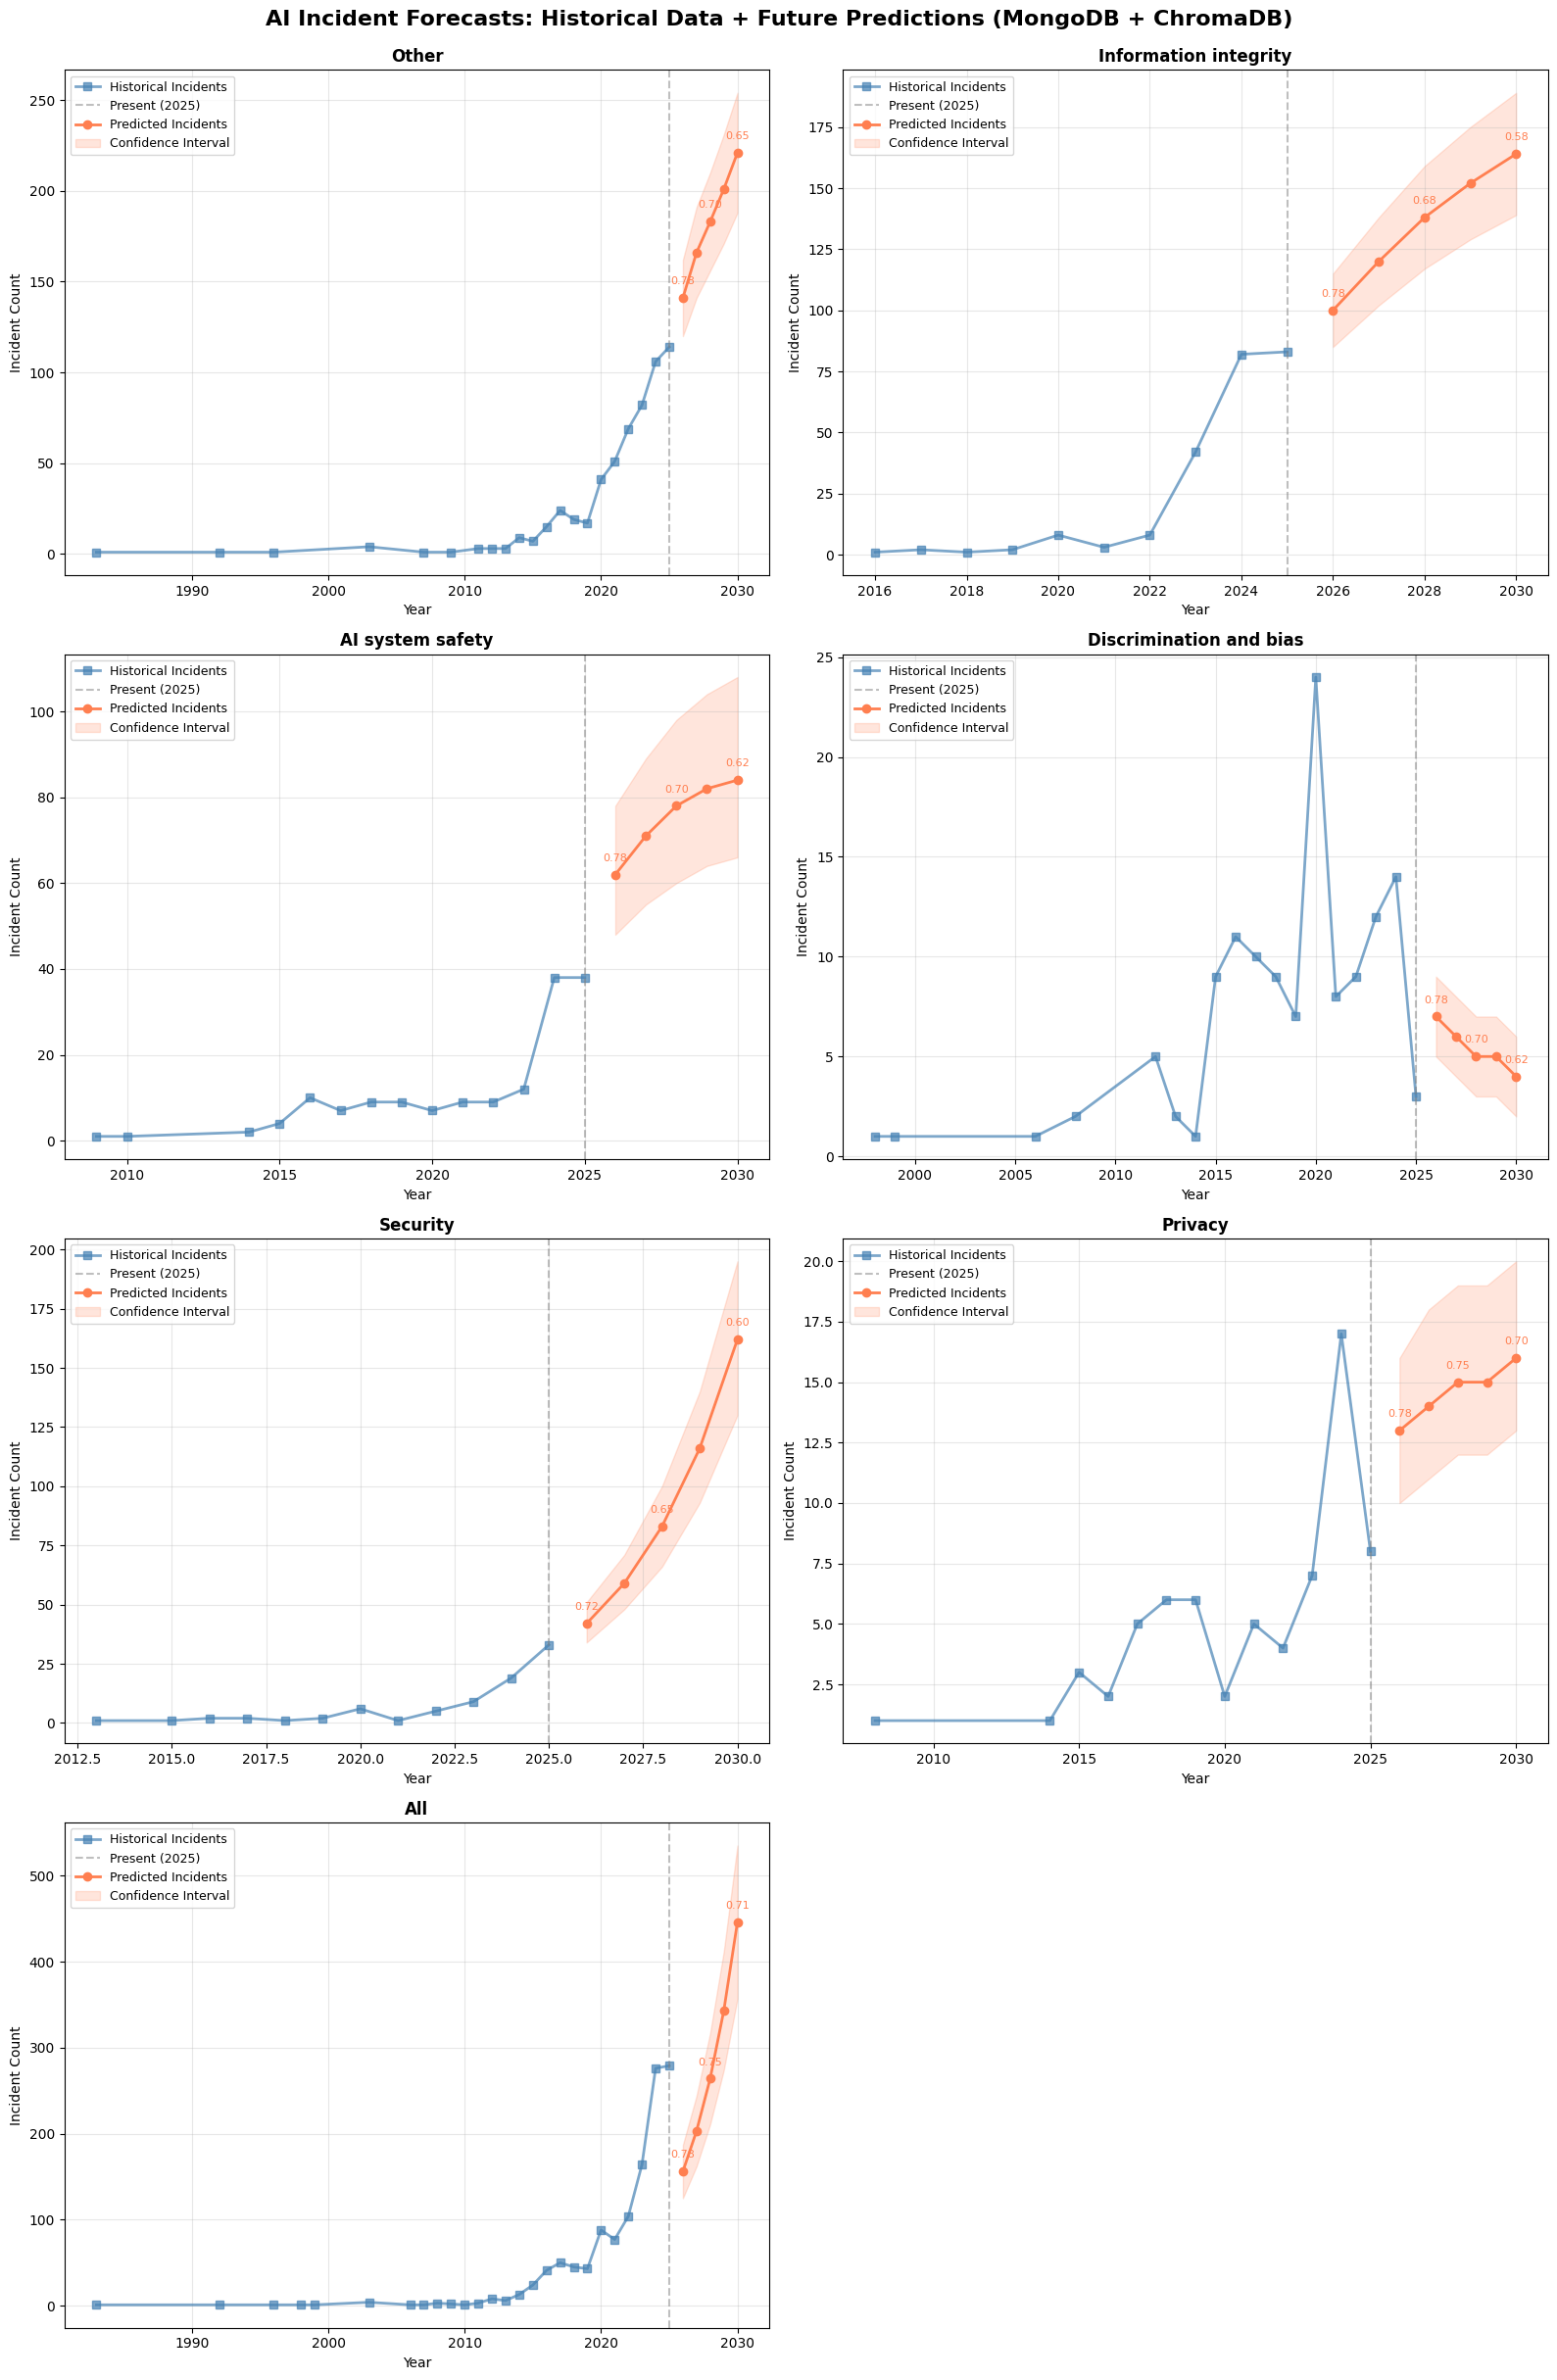

In [ ]:
# Visualize enhanced forecast results with historical data
if enhanced_forecasts:
    import matplotlib.pyplot as plt

    plt.style.use('default')
    
    # Calculate grid size
    n_forecasts = len(enhanced_forecasts)
    n_cols = 2
    n_rows = (n_forecasts + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for idx, (risk_area, forecast_data) in enumerate(enhanced_forecasts.items()):
        if idx >= len(axes):  # Safety check
            break
            
        forecast = forecast_data['forecast']
        if not forecast:  # Skip if forecast is empty
            continue
            
        # Get forecast data
        years = [item['year'] for item in forecast]
        counts = [item['predicted_incident_count'] for item in forecast]
        confidence = [item['confidence'] for item in forecast]
        
        ax = axes[idx]
        
        # Calculate and plot historical data
        if risk_area == "All":
            historical_df = incidents_df.copy()
        else:
            historical_df = incidents_df[incidents_df['Risk Domain'].str.contains(risk_area, case=False, na=False)]
        
        if not historical_df.empty:
            historical_yearly = historical_df.groupby('year').size()
            hist_years = historical_yearly.index.tolist()
            hist_counts = historical_yearly.values.tolist()
            
            # Plot historical data
            ax.plot(hist_years, hist_counts, 's-', linewidth=2, markersize=6, 
                   color='steelblue', label='Historical Incidents', alpha=0.7)
            
            # Add vertical line to separate past and future
            if hist_years:
                current_year = max(hist_years)
                ax.axvline(x=current_year, color='gray', linestyle='--', alpha=0.5, 
                          linewidth=1.5, label=f'Present ({current_year})')
        
        # Plot forecast line
        ax.plot(years, counts, 'o-', linewidth=2, markersize=6, 
               color='coral', label='Predicted Incidents')
        
        # Add confidence intervals for forecast
        if all('confidence_low' in item and 'confidence_high' in item for item in forecast):
            lower_bound = [item['confidence_low'] for item in forecast]
            upper_bound = [item['confidence_high'] for item in forecast]
            ax.fill_between(years, lower_bound, upper_bound, alpha=0.2, 
                           color='coral', label='Confidence Interval')
        else:
            # Fallback confidence intervals
            upper_bound = [c * (1 + (1-conf) * 0.5) for c, conf in zip(counts, confidence)]
            lower_bound = [c * (1 - (1-conf) * 0.5) for c, conf in zip(counts, confidence)]
            ax.fill_between(years, lower_bound, upper_bound, alpha=0.2, 
                           color='coral', label='Confidence Interval')
        
        # Customize plot
        ax.set_title(f"{risk_area}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Incident Count')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=9)
        
        # Add confidence scores as text on forecast points
        for i, (year, count, conf) in enumerate(zip(years, counts, confidence)):
            if i % 2 == 0:  # Show every other confidence score to avoid crowding
                ax.annotate(f'{conf:.2f}', (year, count), 
                           textcoords="offset points", xytext=(0,10), ha='center', 
                           fontsize=8, color='coral')

    # Hide empty subplots
    for idx in range(len(enhanced_forecasts), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.suptitle('AI Incident Forecasts: Historical Data + Future Predictions (MongoDB + ChromaDB)', 
                 fontsize=16, fontweight='bold', y=1.01)
    plt.show()
else:
    print("No enhanced forecasts available for visualization")
    
    # Create a demo plot showing the system capabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Historical data overview
    if not incidents_df.empty:
        yearly_counts = incidents_df.groupby('year').size()
        ax1.plot(yearly_counts.index, yearly_counts.values, 'o-', color='steelblue', linewidth=2)
        ax1.set_title('Historical AI Incidents (Data Source)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Incident Count')
        ax1.grid(True, alpha=0.3)
        
        # Risk domain distribution
        risk_counts = incidents_df['Risk Domain'].value_counts().head(5)
        ax2.bar(range(len(risk_counts)), risk_counts.values, color='lightcoral')
        ax2.set_title('Top Risk Domains in Database', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Risk Domain')
        ax2.set_ylabel('Incident Count')
        ax2.set_xticks(range(len(risk_counts)))
        ax2.set_xticklabels([label[:25] + '...' if len(label) > 25 else label for label in risk_counts.index], 
                           rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('MongoDB + ChromaDB AI Incident Analysis System', fontsize=14, fontweight='bold', y=1.02)
        plt.show()
    else:
        ax1.text(0.5, 0.5, 'No data available\nfor visualization', ha='center', va='center', transform=ax1.transAxes)
        ax2.text(0.5, 0.5, 'Configure MongoDB\nconnection to load data', ha='center', va='center', transform=ax2.transAxes)
        ax1.set_title('Data Visualization')
        ax2.set_title('System Status')
        plt.show()
